34 ms ± 858 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


C:\Users\Talos\Programming\fractals\fractals.py:141: RuntimeWarning: invalid value encountered in remainder
  val %= 1
c:\python37\lib\site-packages\matplotlib\colors.py:512: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


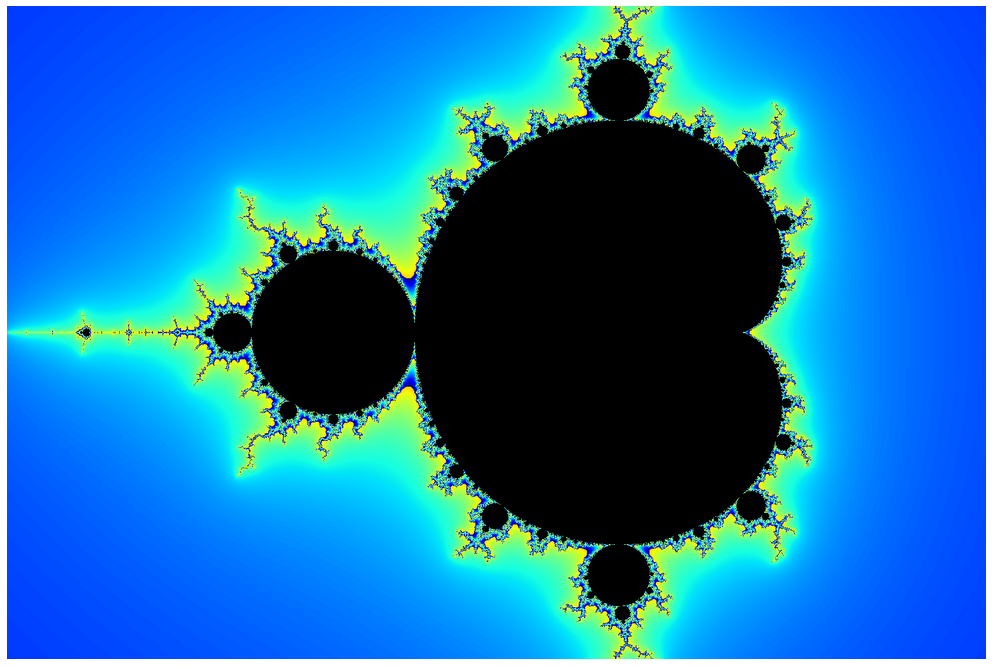

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
import imageio
from tqdm import tqdm
from matplotlib.colors import Colormap
from IPython.display import display

from fractals import *
%matplotlib inline
%load_ext line_profiler

# for cmap in plt.colormaps()[len(plt.colormaps())//2:]:
#     print(cmap)
cmap = 'jet'

coords = create_set((-0.5, 0), 1, res=1024)
val = mandelbrot_gpu(coords, maxiters=300, bailout=128).T
%timeit mandelbrot_gpu(coords, maxiters=300, bailout=128).T
# print(val[500][750])
val = transform(val, density=1)
# val = colorize(val, colormap='mandelbrot')
val = cmap_colorize(val, cmap=cmap)
draw(val, 'mandelbrot')
# for cmap in plt.colormaps()[int(len(plt.colormaps())*2/3):]:
#     print(cmap)
#     val2 = cmap_colorize(val.copy(), cmap=cmap)
#     draw(val2, 'mandelbrot')

# coords = create_set((0, 0), 1, res=1024)
# # print(coords.dtype)
# val = julia_gpu(coords, complex(0.56667, -0.5), maxiters=300, bailout=128).T
# # print(val[np.isnan(val)])
# val = transform(val, density=0.25)
# val = cmap_colorize(val, cmap=cmap)
# # val = colorize(val)
# draw(val, 'julia')

In [2]:
from fractals import *
from multiprocessing import Pool
from IPython.display import display
import datetime
import sys

res = 1024
duration = 12
fps = 30
frames = duration * fps
center = complex(-0.77568377, 0.13646737)
# center = (-1.04180483110546, 0.346342664848392)
zoom = 2 / fps

# coords = create_set((0, 0), 1, res=res)
# coords_list = [coords] * frames
coords = create_set((-0.5, 0), 1, res=res)
def coords_list(coords):
    yield coords
    for _ in range(frames-1):
        delta = (coords - center) * zoom
        coords = coords - delta
        yield coords
        
# def coords_list(coords):
#     view = 1
#     for _ in range(frames):
#         yield create_set(center, view, res=res)
#         view *= zoom

# c_list = np.linspace(0, 2*np.pi, frames, endpoint=False)
# c_list = -0.3 + 0.65 * np.exp(c_list*1j)
# c_vals = np.linspace(0, 1, frames)**complex(1, np.pi*2)

def draw_frame(func, *args, maxiters=300):
    val = func(*args, maxiters=maxiters, bailout=128).T
    val = transform(val)
#     val = colorize(val, colormap='mandelbrot')
    val = cmap_colorize(val, cmap='hsv')
    return val

def frame_generator(func, *args_list):
    args_list = zip(*args_list)
    for i, args in enumerate(args_list):
        maxiters = 300 + 100 * zoom * i
        yield draw_frame(func, *args, maxiters=maxiters)

writer = imageio.get_writer('media/mandelbrot.mp4', fps=fps)
# images = (draw_frame(julia_gpu, coords, c) for coords, c in zip(coords_list, c_list))
images = frame_generator(mandelbrot_gpu, coords_list(coords))
for img in tqdm(images, total=frames):
    writer.append_data(img)

# for a in tqdm(a_vals):
#     images.append(julia_frame((coords, a)))

# with Pool() as pool:
#     images = pool.imap(julia_frame, zip(coords_list, a_vals))
#     for img in tqdm(images, total=frames):
#         writer.append_data(img)

writer.close()
print('Done!')
    
# imageio.mimsave('julia.gif', images, duration=0.04)

  0%|                                                  | 0/360 [00:00<?, ?it/s]C:\Users\Talos\Programming\fractals\fractals.py:141: RuntimeWarning: invalid value encountered in remainder
  val %= 1
c:\python37\lib\site-packages\matplotlib\colors.py:512: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
100%|████████████████████████████████████████| 360/360 [02:00<00:00,  2.81it/s]


Done!


In [ ]:
from fractals import *
from multiprocessing import Pool
import datetime
%matplotlib inline

@vectorize([boolean(complex64, uint16, uint16)], target='cuda')
def escaping(c, maxiters, threshold):
    z = 0
    for it in range(maxiters):
        if z.real*z.real + z.imag*z.imag > threshold:
            return True
        new_z = z*z + c
        if new_z == z:
            return False
        z = new_z
    return False

def buddhabrot(coords, maxiters=100, bailout=2, n_samples=1000000, rgb=None):
    if rgb:
        rgb = np.array(rgb, np.uint16)
        maxiters = rgb.max()
    
    min_v = coords[0, 0]
    max_v = coords[-1, -1]
    step_r = (np.abs(min_v.real) + np.abs(max_v.real)) / (coords.shape[0]-1)
    step_i = (np.abs(min_v.imag) + np.abs(max_v.imag)) / (coords.shape[1]-1)
    threshold = bailout * bailout
    
    if rgb:
        counts = np.zeros(coords.shape + (3,), np.uint16)
    else:
        counts = np.zeros(coords.shape, np.uint16)
    
#     create random complex samples
    min_c = np.complex64(-2 - 1j)
    max_c = np.complex64(0.5 + 1j)
    c = (np.random.uniform(min_c.real, max_c.real, n_samples) + np.random.uniform(min_c.imag, max_c.imag, n_samples) * 1j).astype(np.complex64)

#     cardioid check
    x = c.real
    y = c.imag
    q = (x - 1/4)**2 + y**2
    c = c[q*(q+(x-1/4)) > (1/4)*(y**2)]
#     bulb check
    x = c.real
    y = c.imag
    c = c[(x+1)**2 + y**2 > 1/16]
#     curve check
    x = c.real
    y = c.imag
    c = c[((x**2-y**2+x)**2-(2*x*y+y)**2+x)**2 + (2*(x**2-y**2+x)*(2*x*y+y)+y)**2 < 4]

#     z = np.zeros(c.shape).astype(np.complex64)
# #     check escaping values
#     for it in range(maxiters):
#         notdone = np.less(z.real*z.real + z.imag*z.imag, threshold)
# #         z = z[notdone]
# #         c = c[notdone]
#         z[notdone] = z[notdone]*z[notdone] + c[notdone]
        
#     c = c[~notdone]
    c = c[escaping(c, maxiters, threshold)]
    z = np.zeros(c.shape).astype(np.complex64)
    
#     iterate orbit trajectory
    for it in range(maxiters):
        notdone = np.less(z.real*z.real + z.imag*z.imag, threshold)
        z = z[notdone]
        c = c[notdone]
        z = z*z + c
        
        z_inbounds = z[(min_v.real <= z.real) & (z.real < max_v.real) & (min_v.imag <= z.imag) & (z.imag < max_v.imag)]
        rdx = ((z_inbounds.real - min_v.real) / step_r).astype(np.int16)
        idx = ((z_inbounds.imag - min_v.imag) / step_i).astype(np.int16)
        
        if rgb:
            channels = np.argwhere(rgb > it)[-1]
            counts[rdx, idx, channels] += 1
            counts[rdx, -idx, channels] += 1
        else:
            counts[rdx, idx] += 1
            counts[rdx, -idx] += 1
    
    return counts


#     samples_r = np.random.uniform(s_lim_r[0], s_lim_r[1], n_samples)
#     samples_i = np.random.uniform(s_lim_i[0], s_lim_i[1], n_samples)
    
#     for n in range(n_samples):
#         creal = samples_r[n]
#         cimag = samples_i[n]
#         zreal = 0
#         zimag = 0
#         traj = np.zeros(counts.shape, np.uint16)
#         for it in range(maxiters):
#             zreal2 = zreal*zreal
#             zimag2 = zimag*zimag
#             if zreal2 + zimag2 > threshold:
#                 counts += traj
#                 break
#             zimag = 2 * zreal*zimag + cimag
#             zreal = zreal2 - zimag2 + creal
#             if lim_r[0] <= zreal < lim_r[1] and lim_i[0] <= zimag < lim_i[1]:
#                 rdx = np.uint16((zreal - lim_r[0]) / step_r)
#                 idx = np.uint16((zimag - lim_i[0]) / step_i)
#                 inv_idx = counts.shape[1]-1 - idx
#                 traj[rdx][idx] += 1
#                 traj[rdx][inv_idx] += 1
                
#     return counts.astype(np.int64)
                
coords = create_set((-0.5,0), view=1.5, aspect=1, res=1000).astype(np.complex64)
mil = 1000000

# %load_ext line_profiler
# %lprun -f buddhabrot buddhabrot(coords, maxiters=100, bailout=2, n_samples=int(10*mil), rgb=(5000, 500, 50))

start = datetime.datetime.now()
counts = buddhabrot(coords, maxiters=10000, bailout=2, n_samples=int(100*mil))

# counts = np.zeros(coords.shape, np.int64)
# def add_counts(returned_counts):
#     counts += returned_counts
# workers = 4
# with Pool(workers) as pool:
#     for _ in range(workers):
#         pool.apply_async(buddhabrot, args=(coords, 100, 2, int(2.5*mil)), callback=add_counts)
#     pool.close()
#     pool.join()
print(datetime.datetime.now() - start)

# counts = (255*np.sqrt(counts)/np.sqrt(counts.max())).astype(int)
val = counts.copy()
val = cmap_colorize(counts, cmap='mako')
draw(val, 'buddhabrot')

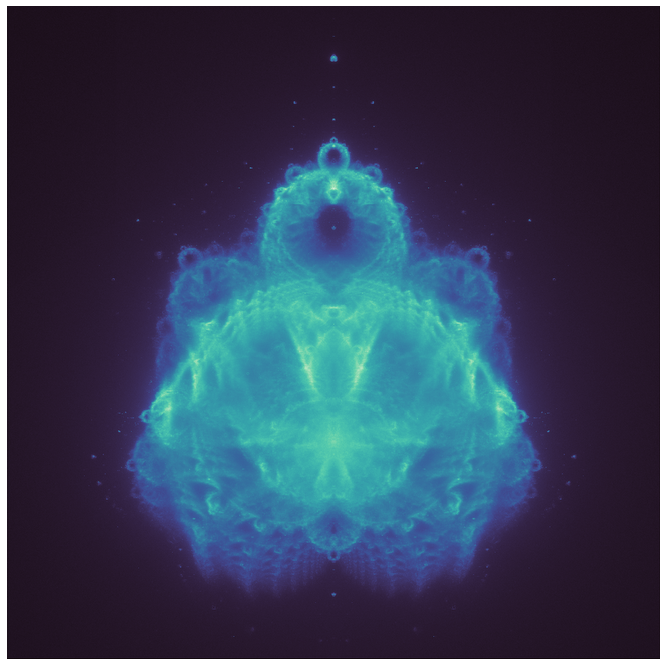

In [12]:
val = counts.copy()
val = np.sqrt(val/val.max())

# for cmap in plt.colormaps():
#     print(cmap)
# val2 = cmap_colorize(val.copy(), cmap='gnuplot2')
# draw(val2)
val2 = cmap_colorize(val.copy(), cmap='mako')
draw(val2, 'buddhabrot')

In [ ]:
val = counts.copy()
for i in range(3):
    val[:,:,i] = 255*np.sqrt(val[:,:,i]/val[:,:,i].max())
draw(val, 'buddhabrot')

val = counts.copy()
for i in range(3):
    val[:,:,i] = 255*np.sqrt(val[:,:,i]/val.max())
draw(val, 'buddhabrot')

In [ ]:
import numpy as np
a = np.zeros((10, 10, 3), int)
a[np.array([1,2,3,4]), np.array([1,2,3,4]), np.array([1])] += 1
a

In [ ]:
coords = create_set((0,0.5), view=2, aspect=1, res=1024).astype(np.complex64)
print(coords.min(), coords.max())

In [ ]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import golden
%matplotlib inline

# x = np.linspace(0, 1, 100)
# # y = x * 1j
# points = x**complex(1, np.pi*4)

points = np.linspace(0, 2*np.pi, 300, endpoint=False)
points = -0.3 + 0.68 * np.exp(points*1j)

df = pd.DataFrame({'x': points.real, 'y': points.imag})
sns.relplot(x='x', y='y', data=df, kind='line', sort=False)